# **2D Map Conjugacy for the Kuramoto-Sivashinsky PDE**

In [1]:
import numpy as np
from utils import Kuramoto
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Set plotting parameters
parameters = {'axes.labelsize': 16,
              'axes.titlesize': 18,
              'legend.fontsize': 13,
              'xtick.labelsize': 16,
              'ytick.labelsize': 16,
              'figure.figsize': (12, 8),
              'figure.titlesize': 18,
              'font.serif': 'Computer Modern Roman',
             }
plt.rcParams.update(parameters)
plt.rc('text', usetex=True)

## **Generate Measurement Data**

In [2]:
# Continuous-time simulation data

# Initializations
dt = .005
nu = 0.021
modes = 14 
t_span = np.arange(0, 5000, dt)
x0 = 0.1*np.random.rand(modes)

# Solution data
xsol = []
xsol = odeint(Kuramoto, x0, t_span,args = (nu,modes,))

Text(0, 0.5, '$x_{10}(t)$')

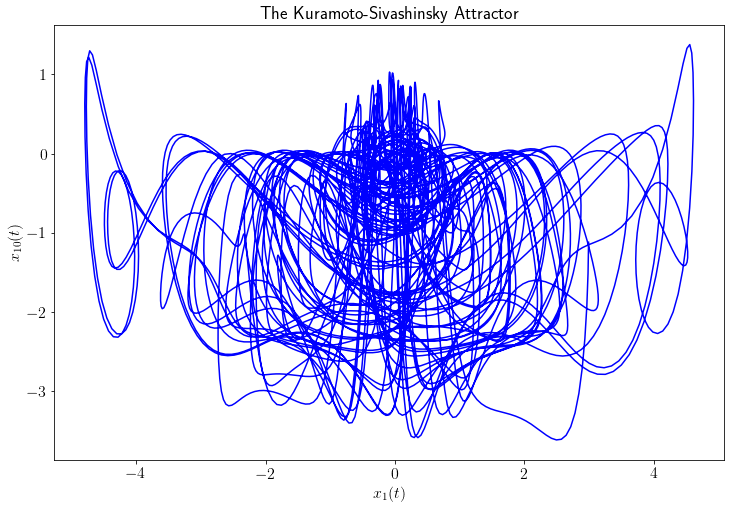

In [3]:
# Plot Kuramoto-Sivashinsky Solution (x_10 vs. x_1)

plt.plot(xsol[1000:10000,0],xsol[1000:10000,9],'b')
plt.title("The Kuramoto-Sivashinsky Attractor")
plt.xlabel("$x_1(t)$")
plt.ylabel("$x_{10}(t)$")

In [6]:
# Create section data

Psec = []
temp = [0]*len(xsol[:,1])
count = 0
for m in range(len(temp)-1):
    if xsol[m,0] <= 0 and xsol[m+1,0] >= 0: # section condition: x_1 = 0
        temp[count] = xsol[m,1:] 
        count = count + 1
Psec.append(np.array(temp[1:count]))   

xn, xnp1 = Psec[0][:-1], Psec[0][1:]

#Scale data
max_xn = xn.max()
min_xn = xn.min()

slope = 1/(max_xn - min_xn)
yint = -slope*min_xn

xn = slope*xn + yint
xnp1 = slope*xnp1 + yint

# Build input data matrix of forward iterates
forward_iters = 50
xnforward = []

xnp1 = xnp1[:-forward_iters] 
for j in range(forward_iters): 
    xnforward.append(xn[j:-forward_iters+j])

Text(0, 0.5, '$x_{2,n+1}$')

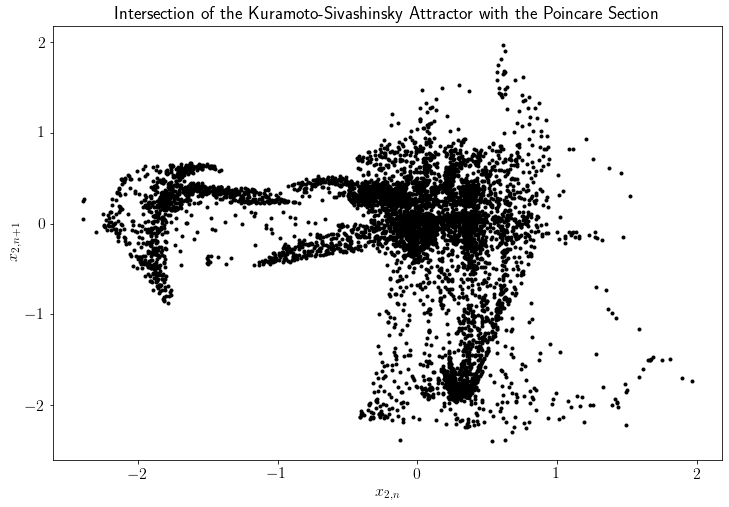

In [7]:
# Plot Rossler Section Data

plt.plot(Psec[0][:-1,1],Psec[0][1:,1],'k.')
plt.title("Intersection of the Kuramoto-Sivashinsky Attractor with the Poincare Section")
plt.xlabel("$x_{2,n}$")
plt.ylabel("$x_{2,n+1}$")

## **Network Architecture and Training**

In [8]:
# Build network

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

# Conjugacy-Net
class Conjugacy(Model):
  def __init__(self,
                 width = 100,
                 size_x = 13,
                 size_y = 1,
                 activation = 'selu',
                 batch_size = 10,
                 steps = 1,
                 numblks_in = 1,
                 numblks_out = 1,
                 l1reg = 0.0,
                 l2reg = 1e-20,
                 **kwargs):
    super(Conjugacy, self).__init__()
    self.width = width
    self.size_x = size_x
    self.size_y = size_y
    self.activation = activation
    self.batch_size = batch_size
    self.steps = steps
    self.numblks_in = numblks_in
    self.numblks_out = numblks_out
    self.l1reg = l1reg
    self.l2reg = l2reg
    self.initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001, seed=None) #0.0001 for 1D map

    # 2D Map coefficient initializations
    #     c: coefficients of g_1
    #     d: coefficients of g_2
    self.c0 = tf.Variable(0.10092687, trainable = True)
    self.c10 = tf.Variable(1.5588915, trainable = True)
    self.c01 = tf.Variable(0.5600656, trainable = True)
    self.c20 = tf.Variable(-0.25340468, trainable = True)
    self.c11 = tf.Variable(-2.4927552, trainable = True)
    self.c02 = tf.Variable(0.445675768, trainable = True)
    self.d0 = tf.Variable(0.6545294, trainable = True)
    self.d10 = tf.Variable(0.40982693, trainable = True)
    self.d01 = tf.Variable(-1.2801967, trainable = True)
    self.d20 = tf.Variable(0.20219931, trainable = True)
    self.d11 = tf.Variable(0.616434, trainable = True)
    self.d02 = tf.Variable(-0.3460362, trainable = True)
    
    # Optional cubic terms
    self.c30 = tf.Variable(0.0, trainable = False)
    self.c21 = tf.Variable(0.0, trainable = False)
    self.c12 = tf.Variable(0.0, trainable = False)
    self.c03 = tf.Variable(0.0, trainable = False)
    self.d30 = tf.Variable(0.0, trainable = False)
    self.d21 = tf.Variable(0.0, trainable = False)
    self.d12 = tf.Variable(0.0, trainable = False)
    self.d03 = tf.Variable(0.0, trainable = False)

    # Encoder function
    self.encoder = tf.keras.Sequential()
    
    for n in range(self.numblks_in): #adding more layers
        self.encoder.add(layers.Dense(self.width, activation=self.activation, 
                                      kernel_initializer=self.initializer, 
                                      kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                      bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    self.encoder.add(layers.Dense(self.size_y, activation=self.activation, 
                                  kernel_initializer=self.initializer,
                                  kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                  bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))

    # Decoder function
    self.decoder = tf.keras.Sequential()
    
    for n in range(self.numblks_out): #adding more layers
        self.decoder.add(layers.Dense(self.width, activation=self.activation, 
                                      kernel_initializer=self.initializer, 
                                      kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                      bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    self.decoder.add(tf.keras.layers.Dense(self.size_x, activation= self.activation, 
                                           kernel_initializer=self.initializer, 
                                           kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                           bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    
  def call(self, x):
    encoded = self.encoder(x[0])
    
    y1np1 = self.c0*tf.ones_like(encoded[:,0]) + self.c10*encoded[:,0] + self.c01*encoded[:,1] + self.c20*tf.square(encoded[:,0]) + self.c11*tf.math.multiply(encoded[:,0],encoded[:,1]) + self.c02*tf.square(encoded[:,1]) + self.c30*tf.math.multiply(encoded[:,0],tf.square(encoded[:,0])) + self.c21*tf.math.multiply(encoded[:,1],tf.square(encoded[:,0])) + self.c12*tf.math.multiply(encoded[:,0],tf.square(encoded[:,1])) + self.c03*tf.math.multiply(encoded[:,1],tf.square(encoded[:,1]))
    y2np1 = self.d0*tf.ones_like(encoded[:,1]) + self.d10*encoded[:,0] + self.d01*encoded[:,1] + self.d20*tf.square(encoded[:,0]) + self.d11*tf.math.multiply(encoded[:,0],encoded[:,1]) + self.d02*tf.square(encoded[:,1]) + self.d30*tf.math.multiply(encoded[:,0],tf.square(encoded[:,0])) + self.d21*tf.math.multiply(encoded[:,1],tf.square(encoded[:,0])) + self.d12*tf.math.multiply(encoded[:,0],tf.square(encoded[:,1])) + self.d03*tf.math.multiply(encoded[:,1],tf.square(encoded[:,1]))
    
    encoded_p1 = tf.stack([y1np1, y2np1], axis = -1)
    decoded = self.decoder(encoded_p1)

    # Conjugacy loss
    x_recon = self.decoder(encoded)
    self.add_loss(tf.reduce_mean(tf.math.square(x[0] - x_recon)))
    
    # Build loss function
    yn = encoded
    for s in range(self.steps):
        ynp1 = self.encoder(x[s+1])
        
        # Iteration loss in y
        y1_step = self.c0*tf.ones_like(yn[:,0]) + self.c10*yn[:,0] + self.c01*yn[:,1] + self.c20*tf.square(yn[:,0]) + self.c11*tf.math.multiply(yn[:,0],yn[:,1]) + self.c02*tf.square(yn[:,1]) + self.c30*tf.math.multiply(yn[:,0],tf.square(yn[:,0])) + self.c21*tf.math.multiply(yn[:,1],tf.square(yn[:,0])) + self.c12*tf.math.multiply(yn[:,0],tf.square(yn[:,1])) + self.c03*tf.math.multiply(yn[:,1],tf.square(yn[:,1]))
        y2_step = self.d0*tf.ones_like(yn[:,1]) + self.d10*yn[:,0] + self.d01*yn[:,1] + self.d20*tf.square(yn[:,0]) + self.d11*tf.math.multiply(yn[:,0],yn[:,1]) + self.d02*tf.square(yn[:,1]) + self.d30*tf.math.multiply(yn[:,0],tf.square(yn[:,0])) + self.d21*tf.math.multiply(yn[:,1],tf.square(yn[:,0])) + self.d12*tf.math.multiply(yn[:,0],tf.square(yn[:,1])) + self.d03*tf.math.multiply(yn[:,1],tf.square(yn[:,1]))
        
        y_step = tf.stack([y1_step, y2_step], axis = -1)
        self.add_loss((tf.reduce_mean(tf.math.square(ynp1 - y_step)))/self.steps)
        
        # Iteration loss in x
        xnp1 = self.decoder(y_step)
        self.add_loss((tf.reduce_mean(tf.math.square(x[s+1] - xnp1)))/self.steps)
        
        yn = y_step
    
    # Scale encoded data to [0,1]x[0,1] interval
    self.add_loss(0.125*(1 - tf.reduce_max(encoded[:,0]))**2)
    self.add_loss(0.125*(1 - tf.reduce_max(encoded[:,1]))**2)
    self.add_loss(0.125*(tf.reduce_min(encoded[:,0]))**2)
    self.add_loss(0.125*(tf.reduce_min(encoded[:,1]))**2)
    self.add_loss(0.125*(1 - tf.reduce_max(encoded_p1[:,0]))**2)
    self.add_loss(0.125*(1 - tf.reduce_max(encoded_p1[:,1]))**2)
    self.add_loss(0.125*(tf.reduce_min(encoded_p1[:,0]))**2)
    self.add_loss(0.125*(tf.reduce_min(encoded_p1[:,1]))**2)
        
    return decoded

In [9]:
# Train network

width = 200
size_x = modes - 1 # variables in the section
size_y = 2 # variables in the conjugated map
activation = 'selu'
batch_size = 10
steps = 1
numblks_in = 4
numblks_out = 4
learning_rate = 0.0001

conjugacy = Conjugacy(width, size_x, size_y, activation, batch_size, steps, numblks_in, numblks_out)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 10) # patience is set intentially low to speed up examples

optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
conjugacy.compile(optimizer=optimizer, loss = 'mse')

conjugacy.fit(xnforward, xnp1, callbacks = [callback], epochs = 1000)

Epoch 1/1000
196/196 [==============================] - 1s 4ms/step - loss: 0.7457
Epoch 2/1000
196/196 [==============================] - 1s 3ms/step - loss: 0.1398
Epoch 3/1000
196/196 [==============================] - 1s 4ms/step - loss: 0.1287
Epoch 4/1000
196/196 [==============================] - 1s 4ms/step - loss: 0.1216
Epoch 5/1000
196/196 [==============================] - 1s 4ms/step - loss: 0.1153
Epoch 6/1000
196/196 [==============================] - 1s 4ms/step - loss: 0.1105
Epoch 7/1000
196/196 [==============================] - 1s 4ms/step - loss: 0.1103
Epoch 8/1000
196/196 [==============================] - 1s 4ms/step - loss: 0.1062
Epoch 9/1000
196/196 [==============================] - 1s 4ms/step - loss: 0.1043
Epoch 10/1000
196/196 [==============================] - 1s 4ms/step - loss: 0.1038
Epoch 11/1000
196/196 [==============================] - 1s 4ms/step - loss: 0.1043
Epoch 12/1000
196/196 [==============================] - 1s 4ms/step - loss: 0.1000
E

## **Network Output**

In [11]:
# Print Discovered Mapping

print('Discovered Conjugate Mapping:')
print('g1(y1,y2) = ',conjugacy.c0.numpy(),'+',conjugacy.c10.numpy(),'*y1','+',conjugacy.c01.numpy(),'*y2','+',conjugacy.c20.numpy(),'*y1^2','+',conjugacy.c11.numpy(),'*y1*y2','+',conjugacy.c02.numpy(),'*y2^2')
print('g2(y1,y2) = ',conjugacy.d0.numpy(),'+',conjugacy.d10.numpy(),'*y1','+',conjugacy.d01.numpy(),'*y2','+',conjugacy.d20.numpy(),'*y1^2','+',conjugacy.d11.numpy(),'*y1*y2','+',conjugacy.d02.numpy(),'*y2^2')

# Network Summary
print('')
conjugacy.summary()

Discovered Conjugate Mapping:
g1(y1,y2) =  0.3170767 + 1.616012 *y1 + 0.5606523 *y2 + -0.33603188 *y1^2 + -2.608792 *y1*y2 + 0.3084939 *y2^2
g2(y1,y2) =  0.88168496 + 0.40606865 *y1 + -1.3438405 *y2 + 0.08399347 *y1^2 + 0.4797682 *y1*y2 + -0.4879687 *y2^2

Model: "conjugacy"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 2)                 123802    
_________________________________________________________________
sequential_1 (Sequential)    (None, 13)                123813    
Total params: 247,635
Trainable params: 247,627
Non-trainable params: 8
_________________________________________________________________
